In [1]:
%matplotlib inline

from nuscenes import NuScenes
# Load the dataset
nusc = NuScenes(version='v1.0-mini', dataroot='./data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.444 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
# View class statistics
nusc.list_lidarseg_categories(sort_by='count')

Calculating semantic point stats for nuScenes-lidarseg...
  1  animal                                   nbr_points=           0
  7  human.pedestrian.stroller                nbr_points=           0
  8  human.pedestrian.wheelchair              nbr_points=           0
 19  vehicle.emergency.ambulance              nbr_points=           0
 20  vehicle.emergency.police                 nbr_points=           0
 10  movable_object.debris                    nbr_points=          48
  6  human.pedestrian.police_officer          nbr_points=          64
  3  human.pedestrian.child                   nbr_points=         230
  4  human.pedestrian.construction_worker     nbr_points=       1,412
 14  vehicle.bicycle                          nbr_points=       1,463
 11  movable_object.pushable_pullable         nbr_points=       2,293
  5  human.pedestrian.personal_mobility       nbr_points=       4,096
 13  static_object.bicycle_rack               nbr_points=       4,476
 12  movable_object.trafficcone 

Sample 106


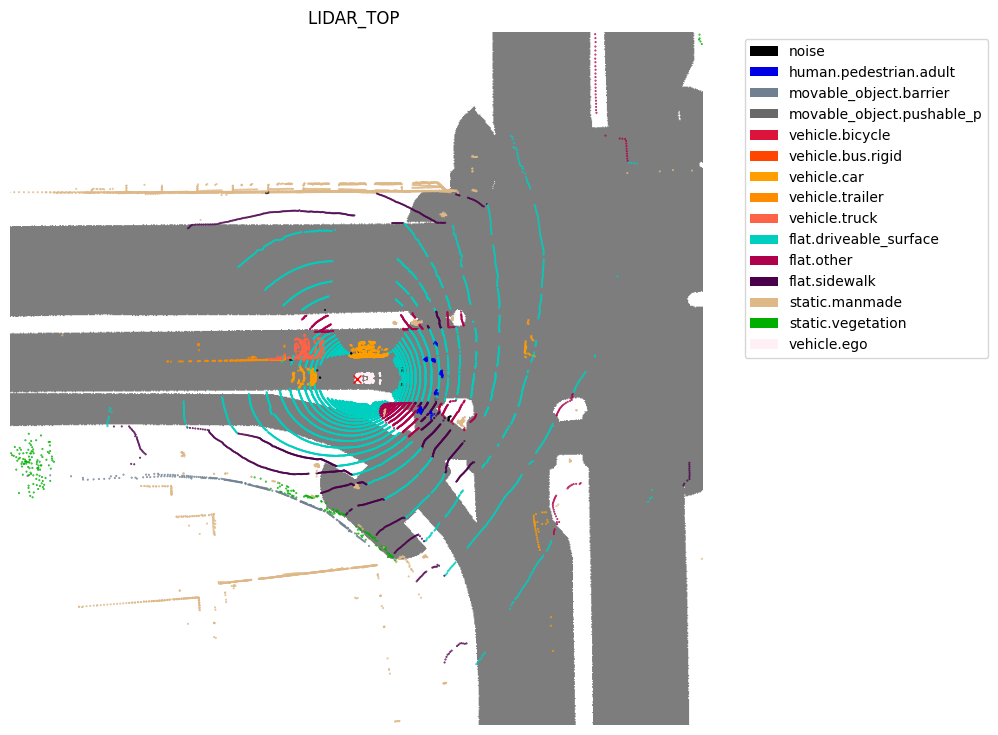

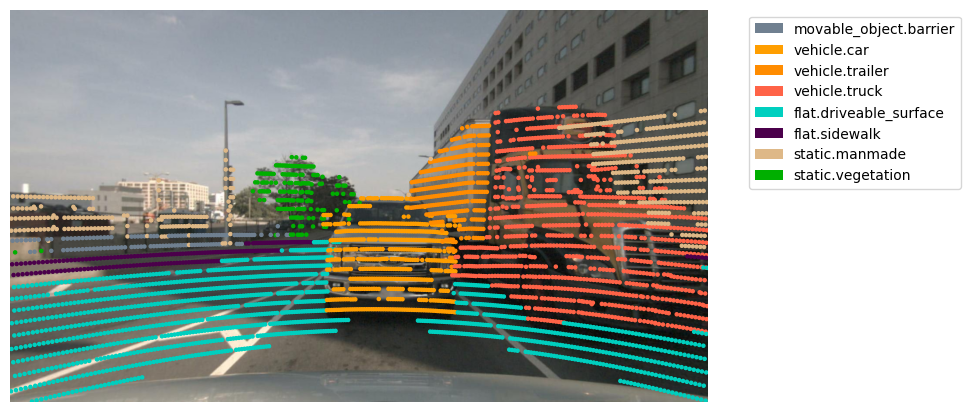

In [3]:
# Visualize a random sample
import random

sample_i = random.randint(0, len(nusc.sample) - 1)
nusc_sample = nusc.sample[sample_i]
sample_data_token = nusc_sample["data"]["LIDAR_TOP"]
print(f"Sample {sample_i}")
# A top-level view of the lidar sample
nusc.render_sample_data(
    sample_data_token, with_anns=False, show_lidarseg=True, show_lidarseg_legend=True
)
# Point-cloud fused onto the camera image using the calibrated rotation,
# translation, and scaling matrices.
nusc.render_pointcloud_in_image(
    nusc_sample["token"],
    pointsensor_channel="LIDAR_TOP",
    camera_channel="CAM_BACK",
    render_intensity=False,
    show_lidarseg=True,
    show_lidarseg_legend=True,
)


In [4]:
import os
from typing import TypedDict

import numpy as np
from nuscenes.utils.data_classes import LidarPointCloud


class Sample(TypedDict):
    X: np.ndarray
    y: np.ndarray
    sample_id: str
    scene_id: str


def load_sample(nusc_sample: dict) -> Sample:
    """
    A helper function which takes a Nuscenes sample and loads the underlying pointcloud
    matrix X and segmentation label vector y. X is a (4, num_points) matrix, with each column
    containing (x, y, z, intensity).
    """
    sample_data_token = nusc_sample["data"]["LIDAR_TOP"]
    # load pointcloud
    ref_sd_record = nusc.get("sample_data", sample_data_token)
    pcl_path = os.path.join(nusc.dataroot, ref_sd_record["filename"])
    X = LidarPointCloud.from_file(pcl_path).points  # the points
    # load labels for pointcloud
    lidarseg_labels_filename = os.path.join(
        nusc.dataroot, nusc.get("lidarseg", sample_data_token)["filename"]
    )
    y = np.fromfile(lidarseg_labels_filename, dtype=np.uint8)  # the segmentation labels
    return {
        "X": X,
        "y": y,
        "scene_id": nusc_sample["scene_token"],
        "sample_id": nusc_sample["token"],
    }


s = load_sample(nusc_sample)
print(s["X"].shape, s["X"].dtype, s["y"].shape, s["y"].dtype)

(4, 34720) float32 (34720,) uint8


Let's make a train/validation split from the data. We should split by scene because samples within the same scene likely share much in common, so evaluating in-scene would not adequately estimate the true generalizability of the model.

In [5]:
def shuffle(data: list) -> list:
    return random.sample(data, len(data))


samples = [load_sample(ns) for ns in nusc.sample]
scene_ids = list({s["scene_id"] for s in samples})
n_scenes = len(scene_ids)
print(f"There are {n_scenes} scenes.")
train_ratio = 0.7
n_train_scenes = int(n_scenes * train_ratio)
shuffled_scene_ids = shuffle(scene_ids)
train_scenes = set(shuffled_scene_ids[:n_train_scenes])
val_scenes = set(shuffled_scene_ids[n_train_scenes:])
print(
    f"Using {len(train_scenes)} scenes for training and {len(val_scenes)} for validation."
)
train = shuffle([s for s in samples if s["scene_id"] in train_scenes])
val = shuffle([s for s in samples if s["scene_id"] in val_scenes])
print(f"Using {len(train)} samples for training and {len(val)} for validation.")

There are 10 scenes.
Using 7 scenes for training and 3 for validation.
Using 282 samples for training and 122 for validation.


In this notebook we'll consider the problem of segmenting the driveable surfaces from the rest of the data. This is a binary segmentation task. We'll have class `1` represent a driveable surface and `0` represent everything else. First we'll update the labels to reflect these two classes.

In [6]:
def with_binary_labels(s: Sample) -> Sample:
    return {**s, "y": (s["y"] == 24).astype(np.uint8)}


train = [with_binary_labels(s) for s in train]
val = [with_binary_labels(s) for s in val]
dataset = train + val

Let's check the distribution of points per sample.

In [7]:
from collections import Counter
Counter(s["X"].shape[1] for s in dataset)

Counter({34720: 190,
         34688: 90,
         34752: 84,
         34784: 24,
         34656: 8,
         34400: 2,
         34624: 2,
         34560: 1,
         34464: 1,
         34368: 1,
         34816: 1})

There is an inconstant number of points per sample. For simplicity in this notebook, we'll downsample to a common size, randomly sampling a subset of points from each sample.

In [ ]:
n_points_per_sample = min(s["X"].shape[1] for s in dataset)
print(f"Downsampling to {n_points_per_sample} points per sample.")
rng = np.random.default_rng(0)


def downsample(s: Sample, n: int) -> Sample:
    """Downsamples sample `s` to have just `n` points. Samples without replacement."""
    i = rng.permutation(n)
    return {**s, "X": s["X"][:, i], "y": s["y"][i]}


train = [downsample(s, n_points_per_sample) for s in train]
val = [downsample(s, n_points_per_sample) for s in val]
dataset = train + val
Counter(s["X"].shape[1] for s in dataset)

Downsampling to 34368 points per sample.


Counter({34368: 404})

For this binary classification task, let's start with a baseline to compare future modeling approaches against. One reasonable baseline is a rule-based model that, by fitting on the training data, determines an optimal Z-axis threshold value $z^*$ for classification. If $z \le z^*$, we classify the point as driveable surface. If $z > z^*$, we classify the point as non-driveable. This baseline method should work better the flatter the driving surface is, but for non-flat driving scenarios, it should work very poorly.

In [ ]:
X_train = np.stack([s["X"] for s in train])
Y_train = np.stack([s["y"] for s in train])
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
Z = X_train[:, 2, :].reshape((-1, 1)) # column vector of all z values
Y = Y_train.reshape((-1, 1)) # column vector of all y values
assert Z.shape == Y.shape
z_min, z_max = Z.min(), Z.max()
print(f"z_min: {z_min}, z_max: {z_max}")
n_candidates = 1000
candidates = np.linspace(z_min, z_max, n_candidates).reshape((1, -1)) # row vector
candidate_accuracies = ((Z <= candidates) == Y).mean(axis=0)
train_accuracy = candidate_accuracies.max()
z_star_i = candidate_accuracies.argmax()
z_star = candidates.flatten()[z_star_i]
print(f"Found z_star of {z_star:.6f} with train accuracy {train_accuracy:.4f}")

X_train shape: (282, 4, 34368), Y_train shape: (282, 34368)
z_min: -41.96949005126953, z_max: 19.369491577148438
Found z_star of -1.568039 with train accuracy 0.8660


An accuracy of 86% is to be expected. There is likely some variation in the height of the driveable surface, and this is an extremly underparameterized, low-variance, high-bias baseline model. Let's see what the generalization accuracy is on the validation set.

In [33]:
X_val = np.stack([s["X"] for s in val])
Y_val = np.stack([s["y"] for s in val])
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
val_accuracy = ((X_val[:, 2, :] <= z_star) == Y_val).mean()
print(f"Val accuracy: {val_accuracy:.4f}")

X_val shape: (122, 4, 34368), Y_val shape: (122, 34368)
Val accuracy: 0.8666


Validation accuracy is nearly identical to training accuracy. This reinforces the fact that the model is very low-variance and high bias. 